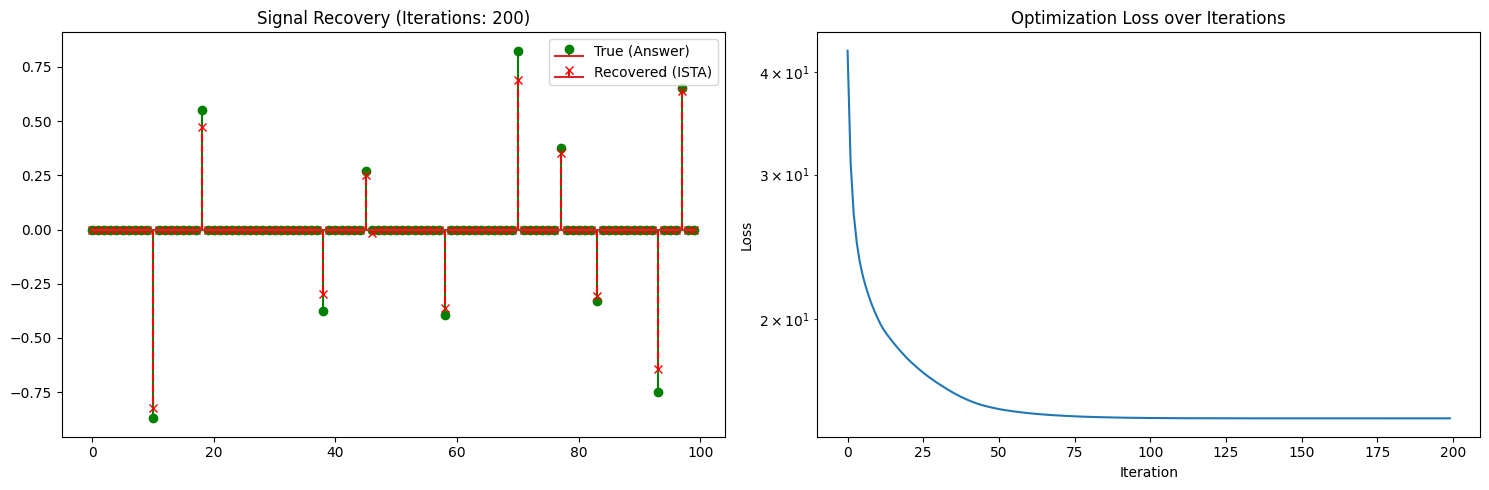

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def soft_thresholding(x, theta):
    """ソフトしきい値関数: 小さい値を0に、大きい値を0方向に引き寄せる"""
    return np.sign(x) * np.maximum(np.abs(x) - theta, 0)

def ista(y, D, alpha, iterations, theta):
    """
    ISTAアルゴリズム
    y: 観測信号 (input_dim,)
    D: 辞書行列 (input_dim, hidden_dim)
    alpha: ステップサイズ (1 / L, LはD^T Dの最大固有値)
    iterations: 繰り返しの回数
    theta: しきい値 (lambda * alpha)
    """
    x = np.zeros(D.shape[1]) # 推定するスパース信号の初期値

    loss_history = []

    for i in range(iterations):
        # 1. 勾配計算（データを再現しようとする修正指示）
        # x_next = x + alpha * D.T * (y - D*x)
        residual = y - np.dot(D, x)
        gradient_step = x + alpha * np.dot(D.T, residual)

        # 2. ソフトしきい値処理（スパース化：値を0に削る）
        x = soft_thresholding(gradient_step, theta)

        # 記録用：再構成誤差の計算
        loss = 0.5 * np.sum((y - np.dot(D, x))**2) + (theta/alpha) * np.sum(np.abs(x))
        loss_history.append(loss)

    return x, loss_history

# --- テストデータの準備 ---
np.random.seed(42)
input_dim = 50   # 観測データの次元
hidden_dim = 100 # 辞書の要素数（パーツの数）

# 1. 辞書 D の作成（ランダム）
D = np.random.randn(input_dim, hidden_dim)
# ステップサイズ alpha の計算（収束のために D^T D の最大固有値の逆数より小さくする）
L = np.linalg.norm(D, ord=2)**2
alpha = 1.0 / L

# 2. 真のスパース信号 x_true の作成（10個だけ値があるトゲトゲ信号）
x_true = np.zeros(hidden_dim)
indices = np.random.choice(hidden_dim, 10, replace=False)
x_true[indices] = np.random.randn(10)

# 3. 観測信号 y の作成 (y = Dx + ノイズ)
y = np.dot(D, x_true) + np.random.randn(input_dim) * 0.05

# --- ISTA の実行 ---
iterations = 200
theta = 0.01 # スパース性の強さ
x_recovered, history = ista(y, D, alpha, iterations, theta)

# --- 結果の可視化 ---
plt.figure(figsize=(15, 5))

# 信号の復元具合
plt.subplot(1, 2, 1)
plt.stem(x_true, linefmt='g-', markerfmt='go', label='True (Answer)')
plt.stem(x_recovered, linefmt='r--', markerfmt='rx', label='Recovered (ISTA)')
plt.title(f"Signal Recovery (Iterations: {iterations})")
plt.legend()

# 誤差の収束
plt.subplot(1, 2, 2)
plt.plot(history)
plt.yscale('log')
plt.title("Optimization Loss over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.tight_layout()
plt.show()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def show_heatmapu(data):
  plt.figure(figsize=(8, 6))
  # cmap='viridis' や 'magma', 'coolwarm' などで色調を変更可能
  sns.heatmap(data, cmap='viridis', cbar=True)
  plt.title("2D Array Heatmap")
  plt.show()

def svt(M, tau):
  U, S, Vh = np.linalg.svd(M, full_matrices=False)
  S_thresh = np.maximum(S - tau, 0)
  return np.dot(U * S_thresh, Vh)

def soft_threshold(x, lam):
    """ソフトしきい値関数"""
    return np.sign(x) * np.maximum(np.abs(x) - lam, 0)

In [2]:
# --- テストデータの準備 ---
np.random.seed(42)
input_dim = 50   # 観測データの次元
hidden_dim = 100 # 辞書の要素数（パーツの数）

# 1. 辞書 D の作成（ランダム）
D = np.random.randn(input_dim, hidden_dim)
# ステップサイズ alpha の計算（収束のために D^T D の最大固有値の逆数より小さくする）
L = np.linalg.norm(D, ord=2)**2
alpha = 1.0 / L

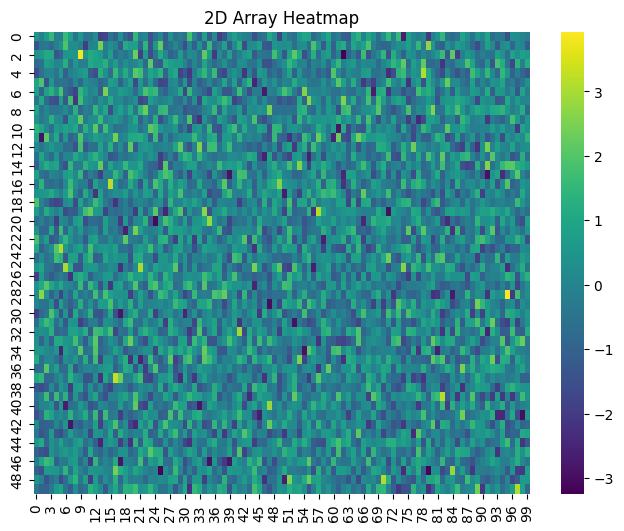

In [5]:
show_heatmapu(D)

行列 $D$ に対して ord=2 を指定した場合、それは 最大特異値 ($\sigma_{max}$) と一致します。

$$\|D\|_2 = \sigma_{max}(D)$$

- 特異値分解（SVD）を行った際の、最も大きい $S$（対角行列）の値そのものです。もし $D$ が正方行列で対称行列であれば、これは「絶対値が最大の固有値」に等しくなります。

In [8]:
L = np.linalg.norm(D, ord=2)**2
L

np.float64(294.9181066700437)

In [9]:
# 2. 真のスパース信号 x_true の作成（10個だけ値があるトゲトゲ信号）
x_true = np.zeros(hidden_dim)
indices = np.random.choice(hidden_dim, 10, replace=False)
x_true[indices] = np.random.randn(10)

# 3. 観測信号 y の作成 (y = Dx + ノイズ)
y = np.dot(D, x_true) + np.random.randn(input_dim) * 0.05

数学的には、以下のコスト関数 $F(x)$ を最小にする $x$ を探しています。$$F(x) = \underbrace{\frac{1}{2} \|y - Dx\|_2^2}_{\text{データへの適合（再現誤差）}} + \underbrace{\lambda \|x\|_1}_{\text{スパース性（L1ノルム）}}$$各ステップで行われている計算を分解して解説します。

$$x^{(k)} + \alpha D^T (y - Dx^{(k)})$$$y - Dx$: 再現しきれていない「残差（エラー）」です。$D^T (\dots)$: そのエラーを解消するために、$x$ のどの要素をどれくらい修正すべきかという方向（勾配）を計算しています。$\alpha$ (alpha): 修正の「歩幅（ステップサイズ）」です。

2. ソフトしきい値処理（Proximal Step / Sparse Update）

1番のステップだけだと、$x$ には細かい数値がたくさん残ってしまいます。

ここで「スパース性（ほとんどを0にする）」を強制します。

数式では ソフトしきい値関数 $\eta_{\theta}$ を適用しています：$$x^{(k+1)} = \text{sign}(z) \cdot \max(|z| - \theta, 0) \quad (\text{where } z = \text{gradient\_step})$$役割: 値が小さい要素（$\theta$以下）を 0 に押し潰し、大きな値だけを残します。これにより、「本当に重要な特徴（主成分や異常）」だけが $x$ に残るようになります。

In [13]:
def soft_thresholding(x, theta):
    """ソフトしきい値関数: 小さい値を0に、大きい値を0方向に引き寄せる"""
    return np.sign(x) * np.maximum(np.abs(x) - theta, 0)

def ista(y, D, alpha, iterations, theta):
    """
    ISTAアルゴリズム
    y: 観測信号 (input_dim,)
    D: 辞書行列 (input_dim, hidden_dim)
    alpha: ステップサイズ (1 / L, LはD^T Dの最大固有値)
    iterations: 繰り返しの回数
    theta: しきい値 (lambda * alpha)
    """
    x = np.zeros(D.shape[1]) # 推定するスパース信号の初期値

    loss_history = []

    for i in range(iterations):
        # 1. 勾配計算（データを再現しようとする修正指示）
        # x_next = x + alpha * D.T * (y - D*x)
        residual = y - np.dot(D, x)
        gradient_step = x + alpha * np.dot(D.T, residual)

        # 2. ソフトしきい値処理（スパース化：値を0に削る）
        x = soft_thresholding(gradient_step, theta)

        # 記録用：再構成誤差の計算
        loss = 0.5 * np.sum((y - np.dot(D, x))**2) + (theta/alpha) * np.sum(np.abs(x))
        loss_history.append(loss)

    return x, loss_history

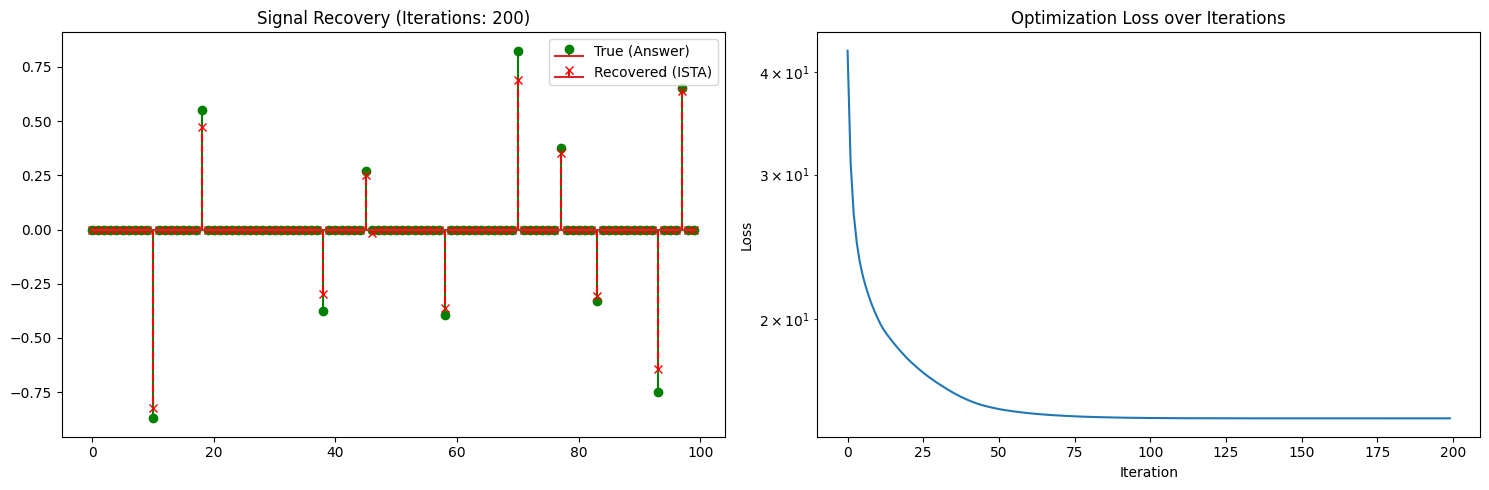

In [14]:
# --- ISTA の実行 ---
iterations = 200
theta = 0.01 # スパース性の強さ
x_recovered, history = ista(y, D, alpha, iterations, theta)

# --- 結果の可視化 ---
plt.figure(figsize=(15, 5))

# 信号の復元具合
plt.subplot(1, 2, 1)
plt.stem(x_true, linefmt='g-', markerfmt='go', label='True (Answer)')
plt.stem(x_recovered, linefmt='r--', markerfmt='rx', label='Recovered (ISTA)')
plt.title(f"Signal Recovery (Iterations: {iterations})")
plt.legend()

# 誤差の収束
plt.subplot(1, 2, 2)
plt.plot(history)
plt.yscale('log')
plt.title("Optimization Loss over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.tight_layout()
plt.show()